In [1]:
# 导入库
import os
import math
import argparse
import scipy.stats as stats
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
# 定义VRPDataset类
class VRPDataset(Dataset):
    def __init__(self, num_samples, num_nodes, max_load=30, max_demand=9, seed=42):
        super().__init__()
        assert max_load >= max_demand, 'Max load should be greater than or equal to max demand.'
        
        self.num_samples = num_samples
        
        generator = torch.Generator()
        generator.manual_seed(seed)
        
        # static: (num_samples, num_nodes + 1, 2)
        self.static = torch.rand((num_samples, num_nodes + 1, 2), generator=generator)
        # capacity: (num_samples, num_nodes + 1)
        capacity = torch.ones(num_samples, num_nodes + 1)
        # demand: (num_samples, num_nodes + 1)
        demand = torch.randint(1, max_demand + 1, (num_samples, num_nodes + 1), generator=generator).float()
        demand[:, 0] = 0.
        demand = demand / max_load
        # dynamic: (num_samples, num_nodes + 1, 2)
        self.dynamic = torch.stack((capacity, demand), dim=2)
        
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        return self.static[idx], self.dynamic[idx]

In [3]:
# 定义update_vrp函数
def update_vrp(dynamic, idxs):
    # dynamic: (batch_size, seq_len, 2)
    # idxs: (batch_size,)
    batch_size, seq_len, _ = dynamic.size()
    num_nodes = seq_len - 1
    
    # capacity: (batch_size,)
    capacity = dynamic[:, 0, 0].clone()
    # demand: (batch_size, num_nodes)
    demand = dynamic[:, 1:, 1].clone()
    # seletect_demand: (batch_size,)
    selected_demand = demand[torch.arange(batch_size), idxs - 1]
    
    # not_depot: (batch_size,)
    not_depot = idxs.ne(0)
    if not_depot.any():
        new_capacity = torch.clamp(capacity - selected_demand, min=0)
        new_demand = torch.clamp(selected_demand - capacity, min=0)
        capacity[not_depot] = new_capacity[not_depot]
        demand[torch.arange(batch_size, device=idxs.device)[not_depot], idxs[not_depot] - 1] = new_demand[not_depot]
        
    # at_depot: (batch_size,)
    at_depot = ~not_depot
    if at_depot.any():
        capacity[at_depot] = 1.
        
    if demand.eq(0).all():
        # mask: (batch_size, seq_len)
        mask = torch.ones(batch_size, seq_len, dtype=torch.bool, device=idxs.device)
    else:
        # mask_depot: (batch_size,)
        mask_depot = idxs.eq(0)
        # has_no_demand: (batch_size,)
        has_no_demand = demand.sum(dim=1).eq(0)
        mask_depot[has_no_demand] = False
        # mask_customer: (batch_size, num_nodes)
        mask_customer = demand.eq(0) | demand.gt(capacity.unsqueeze(1).expand(-1, num_nodes))
        # mask: (batch_size, seq_len)
        mask = torch.cat((mask_depot.unsqueeze(1), mask_customer), dim=1)
    
    # capacity: (batch_size, seq_len)
    capacity = capacity.unsqueeze(1).repeat(1, seq_len)
    # demand: (batch_size, seq_len)
    demand = torch.cat((torch.zeros(batch_size, 1, device=idxs.device), demand), dim=1)
    # dynamic: (batch_size, seq_len, 2)
    dynamic = torch.stack((capacity, demand), dim=2)
    
    return dynamic, mask

In [4]:
# 定义reward函数
def reward(static, idxs):
    # static: (batch_size, seq_len, 2)
    # idxs: (batch_size, num_steps)
    batch_size, seq_len, _ = static.size()
    num_steps = idxs.size()
    
    # expanded_idxs: (batch_size, num_steps, 2)
    expanded_idxs = idxs.unsqueeze(2).expand(-1, -1, 2)
    # tour: (batch_size, num_steps, 2)
    tour = torch.gather(static, 1, expanded_idxs)
    # depot: (batch_size, 2)
    depot = static[:, 0, :]
    # distances: (batch_size,)
    distances = torch.norm(tour[:, 1:, :] - tour[:, :-1, :], dim=2).sum(dim=1)
    distances += torch.norm(depot - tour[:, 0, :], dim=1)
    distances += torch.norm(depot - tour[:, -1, :], dim=1)
    
    return distances

In [5]:
# 定义Encoder类
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.embedding = nn.Linear(input_size, hidden_size)
        
    def forward(self, inputs):
        # inputs: (batch_size, seq_len, input_size)
        
        # embedded: (batch_size, seq_len, hidden_size)
        embedded = self.embedding(inputs)
        
        return embedded

In [6]:
# 定义Attention类
class Attention(nn.Module):
    def __init__(self, hidden_size):
        super().__init__()
        
        self.W = nn.Linear(3 * hidden_size, hidden_size, bias=False)
        self.v = nn.Parameter(torch.zeros(1, 1, hidden_size), requires_grad=True)
        
    def forward(self, static_embedding, dynamic_embedding, decoder_hidden, mask):
        # static_embedding, dynamic_embedding: (batch_size, seq_len, hidden_size)
        # decoder_hidden: (batch_size, hidden_size)
        # mask: (batch_size, seq_len)
        batch_size, seq_len, hidden_size = static_embedding.size()
        
        # decoder_hidden: (batch_size, seq_len, hidden_size)
        decoder_hidden = decoder_hidden.unsqueeze(1).expand(-1, seq_len, -1)
        # hidden: (batch_size, seq_len, 3 * hidden_size)
        hidden = torch.cat((static_embedding, dynamic_embedding, decoder_hidden), dim=2)
        # attn_inputs: (batch_size, seq_len, hidden_size)
        attn_inputs = torch.tanh(self.W(hidden))
        # v: (batch_size, 1, hidden_size)
        v = self.v.expand(batch_size, -1, -1)
        # logits: (batch_size, seq_len)
        logits = torch.bmm(v, attn_inputs.permute(0, 2, 1)).squeeze(1)
        mask_clone = mask.clone().bool()
        logits = logits.masked_fill(mask_clone, float('-inf'))
        # probs: (batch_size, seq_len)
        probs = F.softmax(logits, dim=1)
        # context: (batch_size, 1, 2 * hidden_size)
        context = torch.bmm(probs.unsqueeze(1), torch.cat((static_embedding, dynamic_embedding), dim=2))
        
        return context

In [7]:
# 定义PtrNet类
class PtrNet(nn.Module):
    def __init__(self, hidden_size, num_layers=1, dropout=0.1):
        super().__init__()
        
        self.num_layers = num_layers
        
        self.W = nn.Linear(4 * hidden_size, hidden_size, bias=False)
        self.v = nn.Parameter(torch.zeros(1, 1, hidden_size), requires_grad=True)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers, batch_first=True)
        self.attention = Attention(hidden_size)
        
        self.dropout_rnn = nn.Dropout(dropout)
        self.dropout_hh = nn.Dropout(dropout)
        
    def forward(self, static_embedding, dynamic_embedding, decoder_input, last_hh, mask):
        # static_embedding, dynamic_embedding: (batch_size, seq_len, hidden_size)
        # decoder_input: (batch_size, hidden_size)
        # last_hh: (num_layers, batch_size, hidden_size)
        # mask: (batch_size, seq_len)
        batch_size, seq_len, hidden_size = static_embedding.size()
        
        # rnn_out: (batch_size, 1, hidden_size)
        # last_hh: (num_layers, batch_size, hidden_state)
        rnn_out, last_hh = self.gru(decoder_input.unsqueeze(1), last_hh)
        # memory_state: (batch_size, hidden_size)
        if self.num_layers == 1:
            memory_state = last_hh.squeeze(0)
        else:
            memory_state = last_hh[-1]
            
        rnn_out = self.dropout_rnn(rnn_out)
        last_hh = self.dropout_hh(last_hh)
        
        # context: (batch_size, 1, 2 * hidden_size)
        context = self.attention(static_embedding, dynamic_embedding, memory_state, mask)
        # context: (batch_size, seq_len, 2 * hidden_size)
        context = context.expand(-1, seq_len, -1)
        # energy: (batch_size, seq_len, 4 * hidden_size)
        energy = torch.cat((static_embedding, dynamic_embedding, context), dim=2)
        # energy_inputs: (batch_size, seq_len, hidden_size)
        energy_inputs = torch.tanh(self.W(energy))
        # v: (batch_size, 1, hidden_size)
        v = self.v.expand(batch_size, -1, -1)
        # logits: (batch_size, seq_len)
        logits = torch.bmm(v, energy_inputs.permute(0, 2, 1)).squeeze(1)
        
        return logits, last_hh

In [8]:
# 定义Actor类
class Actor(nn.Module):
    def __init__(self, static_size, dynamic_size, hidden_size, C, argmax, update_vap, reward, num_layers=1, dropout=0.1):
        super().__init__()

        self.C = C
        self.argmax = argmax
        self.update_vrp = update_vrp
        self.reward = reward
        
        self.static_encoder = Encoder(static_size, hidden_size)
        self.dynamic_encoder = Encoder(dynamic_size, hidden_size)
        self.pointer = PtrNet(hidden_size, num_layers, dropout)
        
        self.decoder_input = nn.Parameter(torch.zeros(1, hidden_size), requires_grad=True)
        
        self._init_parameters()
        
    def _init_parameters(self):
        for name, param in self.named_parameters():
            if 'weight' in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
                
    def forward(self, static, dynamic, last_hh=None):
        # static: (batch_size, seq_len, static_size)
        # dynamic: (batch_size, seq_len, dynamic_size)
        # last_hh: (num_layers, batch_size, hidden_size)
        batch_size, seq_len, static_size = static.size()
        
        # decoder_input: (batch_size, hidden_size)
        decoder_input = self.decoder_input.expand(batch_size, -1)
        
        # static_embedding, dynamic_embedding: (batch_size, seq_len, hidden_size)
        static_embedding = self.static_encoder(static)
        dynamic_embedding = self.dynamic_encoder(dynamic)
        
        max_steps = 2 * seq_len
        prev_probs, prev_idxs = [], []
        # mask: (batch_size, seq_len)
        mask = torch.zeros(batch_size, seq_len, dtype=torch.bool, device=static.device)
        
        for _ in range(max_steps):
            
            if mask.bool().all():
                break
                
            # logits: (batch_size, seq_len)
            # last_hh: (num_layers, batch_size, seq_len)
            logits, last_hh = self.pointer(static_embedding, dynamic_embedding, decoder_input, last_hh, mask)
            logits = self.C * torch.tanh(logits)
            mask_clone = mask.clone().bool()
            logits = logits.masked_fill(mask_clone, float('-inf'))
            # probs: (batch_size, seq_len)
            probs = F.softmax(logits, dim=1)
            
            # idxs: (batch_size,)
            if self.training or not self.argmax:
                idxs = torch.multinomial(probs, 1).squeeze(1)
            else:
                idxs = torch.argmax(probs, 1)
                
            # dynamic: (batch_size, seq_len, dynamic_size)
            # mask: (batch_size, seq_len)
            dynamic, mask = update_vrp(dynamic, idxs)
            # dynamic_embedding: (batch_size, seq_len, hidden_size)
            dynamic_embedding = self.dynamic_encoder(dynamic)
            # decoder_input: (batch_size, hidden_size)
            decoder_input = static_embedding[torch.arange(batch_size), idxs]
            
            prev_probs.append(probs[torch.arange(batch_size), idxs])
            prev_idxs.append(idxs)
            
        # prev_probs, prev_idxs: (batch_size, num_steps)
        prev_probs = torch.stack(prev_probs, dim=1)
        prev_idxs = torch.stack(prev_idxs, dim=1)
        # rewards: (batch_size,)
        rewards = self.reward(static, prev_idxs)
        
        return rewards, prev_idxs, prev_probs

In [9]:
# 训练
def train(args, train_dataset, val_dataset, baseline_dataset):
    train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False)
    baseline_loader = DataLoader(baseline_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.static_size, args.dynamic_size, args.hidden_size, args.C, False, args.update_vrp, args.reward, args.num_layers, args.dropout).to(args.device)
    baseline_network = Actor(args.static_size, args.dynamic_size, args.hidden_size, args.C, True, args.update_vrp, args.reward, args.num_layers, args.dropout).to(args.device)
    baseline_network.load_state_dict(actor.state_dict())
    baseline_network.eval()
    optimizer = optim.Adam(actor.parameters(), lr=args.lr)
    
    step = 0
    best_length = float('inf')
    writer = SummaryWriter()
    model_path = os.path.join(args.output_dir, args.name)
    
    for epoch in range(args.n_epochs):
        for batch_id, train_batch in enumerate(train_loader):
            actor.train()
            
            # static: (batch_size, seq_len, static_size)
            static = train_batch[0].to(args.device)
            # dynamic: (batch_size, seq_len, dynamic_size)
            dynamic = train_batch[1].to(args.device)
            # rewards: (batch_size,)
            # idxs, probs: (batch_size, num_steps)
            rewards, idxs, probs = actor(static, dynamic.clone())
            # log_probs: (batch_size,)
            log_probs = torch.log(probs.clamp(min=1e-10)).sum(dim=1)
            with torch.no_grad():
                # baseline: (batch_size,)
                baseline, _, _ = baseline_network(static, dynamic.clone())
            # advantage: (batch_size,)
            advantage = rewards - baseline
            # reinforce: (batch_size,)
            reinforce = advantage.detach() * log_probs
            actor_loss = reinforce.mean()
            
            optimizer.zero_grad()
            actor_loss.backward()
            torch.nn.utils.clip_grad_norm_(actor.parameters(), args.max_grad_norm)
            optimizer.step()
            step += 1
            
            writer.add_scalar('Actor_Lorr/train', actor_loss.item(), step)
            writer.add_scalar('Length/train', rewards.mean().item(), step)
            
            if batch_id % 200 == 0:
                print(f"Epoch [{epoch + 1}/{args.n_epochs}], Batch [{batch_id + 1}/{len(train_loader)}], "
                      f"Actor Loss: {actor_loss.item():.4f}, Reward: {rewards.mean().item():.4f}")
                
                actor.eval()
                with torch.no_grad():
                    total_rewards, total_nums = 0, 0
                    for val_batch in val_loader:
                        static = val_batch[0].to(args.device)
                        dynamic = val_batch[1].to(args.device)
                        rewards, _, _ = actor(static, dynamic.clone())
                        total_rewards += rewards.sum().item()
                        total_nums += static.size(0)
                    avg_reward = total_rewards / total_nums
                    writer.add_scalar('Length/validation', avg_reward, step)
                    print(f'Validation average reward after epoch {epoch + 1}: {avg_reward:.4f}')
                    
                    if avg_reward < best_length:
                        best_length = avg_reward
                        torch.save(actor.state_dict(), model_path)
                        
        actor_rewards, baseline_rewards = [], []
        with torch.no_grad():
            for baseline_batch in baseline_loader:
                static = baseline_batch[0].to(args.device)
                dynamic = baseline_batch[1].to(args.device)
                actor_r, _, _ = actor(static, dynamic.clone())
                baseline_r, _, _ = baseline_network(static, dynamic.clone())
                actor_rewards.append(actor_r.cpu())
                baseline_rewards.append(baseline_r.cpu())
        
        actor_rewards = torch.cat(actor_rewards)
        baseline_rewards = torch.cat(baseline_rewards)
        t_stat, p_value = stats.ttest_rel(actor_rewards.numpy(), baseline_rewards.numpy())
        if t_stat < 0:
            p_value_one_sided = p_value / 2
        elif t_stat == 0:
            p_value_one_sided = 0.5
        else:
            p_value_one_sided = 1 - p_value / 2
            
        if p_value_one_sided < args.alpha:
            print(f'Updating baseline network at epoch {epoch + 1}.')
            baseline_network.load_state_dict(actor.state_dict())
        else:
            print(f'Baseline network has not been updated at epoch {epoch + 1}.')
    
    writer.close()

In [10]:
# 参数
args = argparse.Namespace()
args.num_nodes = 20
args.max_load = 30
args.max_demand = 9
args.n_epochs = 100
args.batch_size = 256
args.lr = 1e-4
args.embedding_size = 128
args.static_size = 2
args.dynamic_size = 2
args.hidden_size = 128
args.C = 10
args.num_layers = 1
args.dropout = 0.1
args.max_grad_norm = 2.
args.num_samples = 1280
args.alpha = 0.05
args.update_vrp = update_vrp
args.reward = reward
args.output_dir = 'output'
args.name = 'DRL4VRP_REINFORCE_RolloutBaseline_VRP' + str(args.num_nodes)
args.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

os.makedirs(args.output_dir, exist_ok=True)

train_dataset = VRPDataset(1280000, args.num_nodes, args.max_load, args.max_demand)
val_dataset = VRPDataset(1280, args.num_nodes, args.max_load, args.max_demand)
test_dataset = VRPDataset(1280, args.num_nodes, args.max_load, args.max_demand)
baseline_dataset = VRPDataset(10000, args.num_nodes, args.max_load, args.max_demand)

In [11]:
print('Training started...')
train(args, train_dataset, val_dataset, baseline_dataset)
print('Training completed!')

Training started...
Epoch [1/100], Batch [1/5000], Actor Loss: 357.3496, Reward: 13.2856
Validation average reward after epoch 1: 13.3845
Epoch [1/100], Batch [201/5000], Actor Loss: 360.7009, Reward: 13.1085
Validation average reward after epoch 1: 13.1872
Epoch [1/100], Batch [401/5000], Actor Loss: 361.2855, Reward: 13.1630
Validation average reward after epoch 1: 13.0612
Epoch [1/100], Batch [601/5000], Actor Loss: 339.6202, Reward: 12.9476
Validation average reward after epoch 1: 12.8563
Epoch [1/100], Batch [801/5000], Actor Loss: 326.2153, Reward: 12.6668
Validation average reward after epoch 1: 12.9160
Epoch [1/100], Batch [1001/5000], Actor Loss: 308.0396, Reward: 12.6600
Validation average reward after epoch 1: 12.8066
Epoch [1/100], Batch [1201/5000], Actor Loss: 268.5207, Reward: 12.5275
Validation average reward after epoch 1: 12.6202
Epoch [1/100], Batch [1401/5000], Actor Loss: 278.8706, Reward: 12.5724
Validation average reward after epoch 1: 12.6029
Epoch [1/100], Batc

In [14]:
# 画VRP示例图
def plot_vrp_paths(args, depot, customer, idxs, rewards):
    # depot: (batch_size, 2)
    # customer: (batch_size, num_nodes, 2)
    # idxs: (batch_size, num_steps)
    # rewards: (batch_size,)
    colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple']
    
    # location: (batch_size, seq_len, 2)
    location = torch.cat((depot.unsqueeze(1), customer), dim=1)
    location = location.cpu().numpy()
    depot = depot.cpu().numpy()
    customer = customer.cpu().numpy()
    if isinstance(idxs, list):
        idxs = [idx.cpu().numpy() if torch.is_tensor(idx) else np.array(idx) for idx in idxs]
    else:
        idxs = idxs.cpu().numpy()
    rewards = rewards.cpu().numpy()
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(args.name)
    
    for i in range(8):
        ax = axes[i // 4, i % 4]
        coords = location[i]
        path = idxs[i]
        num = 0

        for j in range(1, len(path)):
            if path[j - 1] == 0 and path[j] != 0:
                num += 1
            x1, y1 = coords[path[j - 1]]
            x2, y2 = coords[path[j]]
            ax.plot([x1, x2], [y1, y2], '-', c=colors[num % len(colors)])  
            if j == 1:
                ax.plot([depot[i][0], x1], [depot[i][1], y1], '-', c=colors[num % len(colors)])  
        ax.plot([depot[i][0], x2], [depot[i][1], y2], '-', c=colors[num % len(colors)])
            
        ax.scatter(coords[1:, 0], coords[1:, 1], c='blue') 
        ax.scatter(coords[0, 0], coords[0, 1], c='red')  
        ax.set_title(f'Length: {rewards[i]:.3f}')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [15]:
# 测试 (greedy)
def test1(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.static_size, args.dynamic_size, args.hidden_size, args.C, False, args.update_vrp, args.reward, args.num_layers, args.dropout).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))
    
    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            static = test_batch[0].to(args.device)
            dynamic = test_batch[1].to(args.device)
            rewards, idxs, _ = actor(static, dynamic.clone())
            total_rewards += rewards.sum().item()
            total_nums += static.size(0)
            
            if i == 0 and static.size(0) >= 8:
                depot = static[:, 0, :]
                customer = static[:, 1:, :]
                plot_vrp_paths(args, depot[:8], customer[:8], idxs[:8], rewards[:8])
                
    avg_reward = total_rewards / total_nums
    print(f"Test average reward: {avg_reward:.4f}")

Test started...


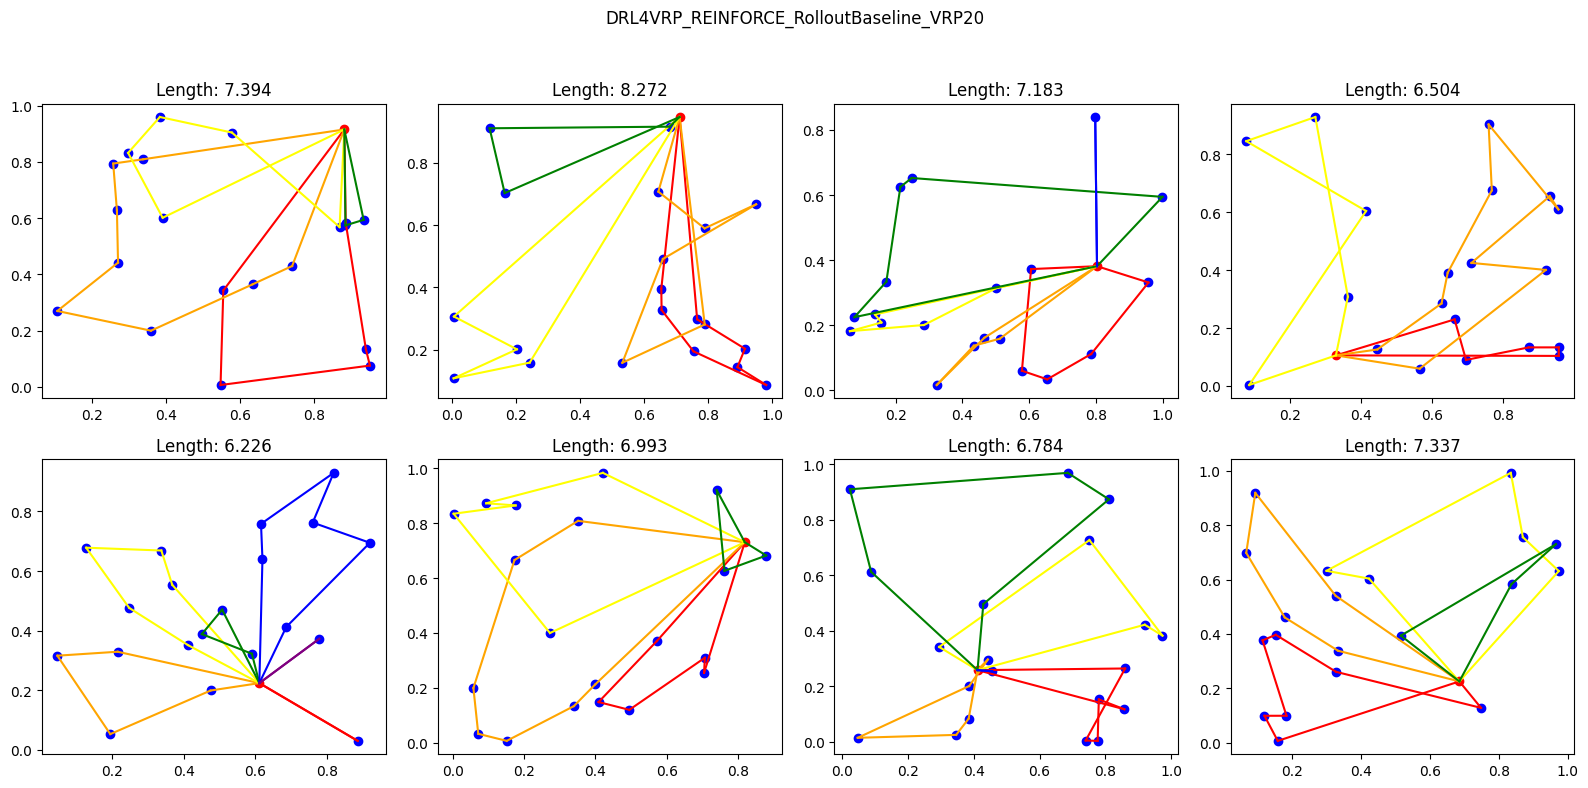

Test average reward: 7.0457
Test completed!


In [16]:
print('Test started...')
test1(args, test_dataset)
print('Test completed!')

In [17]:
# 测试 (sampling)
def sampling(actor, static, dynamic, num_samples, sub_batch_size=1280):
    # static, dynamic: (batch_size, num_nodes, 2)
    batch_size = static.size(0)
    best_idxs, best_rewards = [], []
    
    for i in range(batch_size):
        temp_static = static[i].unsqueeze(0)
        temp_dynamic = dynamic[i].unsqueeze(0)
        best_idx, best_reward = None, float('inf')
        
        num_sub_batches = (num_samples + sub_batch_size - 1) // sub_batch_size
        remaining_samples = num_samples
        for _ in range(num_sub_batches):
            current_batch_size = min(sub_batch_size, remaining_samples)
            remaining_samples -= current_batch_size

            temp_static = temp_static.repeat(current_batch_size, 1, 1)
            temp_dynamic = temp_dynamic.repeat(current_batch_size, 1, 1)
            temp_rewards, temp_idxs, _ = actor(temp_static, temp_dynamic.clone())
            
            sub_best_reward, sub_best_idx = temp_rewards.min(0)
            sub_best_reward = sub_best_reward.item()
            sub_best_idx = temp_idxs[sub_best_idx]
            
            if sub_best_reward < best_reward:
                best_idx = sub_best_idx
                best_reward = sub_best_reward
        
        best_idxs.append(best_idx)
        best_rewards.append(best_reward)

    return torch.tensor(best_rewards, device=static.device), best_idxs


def test2(args, test_dataset):
    test_loader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)
    
    actor = Actor(args.static_size, args.dynamic_size, args.hidden_size, args.C, False, args.update_vrp, args.reward, args.num_layers, args.dropout).to(args.device)
    actor.load_state_dict(torch.load(os.path.join(args.output_dir, args.name)))

    actor.eval()
    total_rewards, total_nums = 0, 0
    
    with torch.no_grad():
        for i, test_batch in enumerate(test_loader):
            static = test_batch[0].to(args.device)
            dynamic = test_batch[1].to(args.device)
            rewards, idxs = sampling(actor, static, dynamic.clone(), args.num_samples)
            total_rewards += rewards.sum().item()
            total_nums += static.size(0)
            
            if i == 0 and static.size(0) >= 8:
                depot = static[:, 0, :]
                customer = static[:, 1:, :]
                plot_vrp_paths(args, depot[:8], customer[:8], idxs[:8], rewards[:8])
                
    avg_reward = total_rewards / total_nums
    print(f"Test average reward: {avg_reward:.4f}")

Test started...


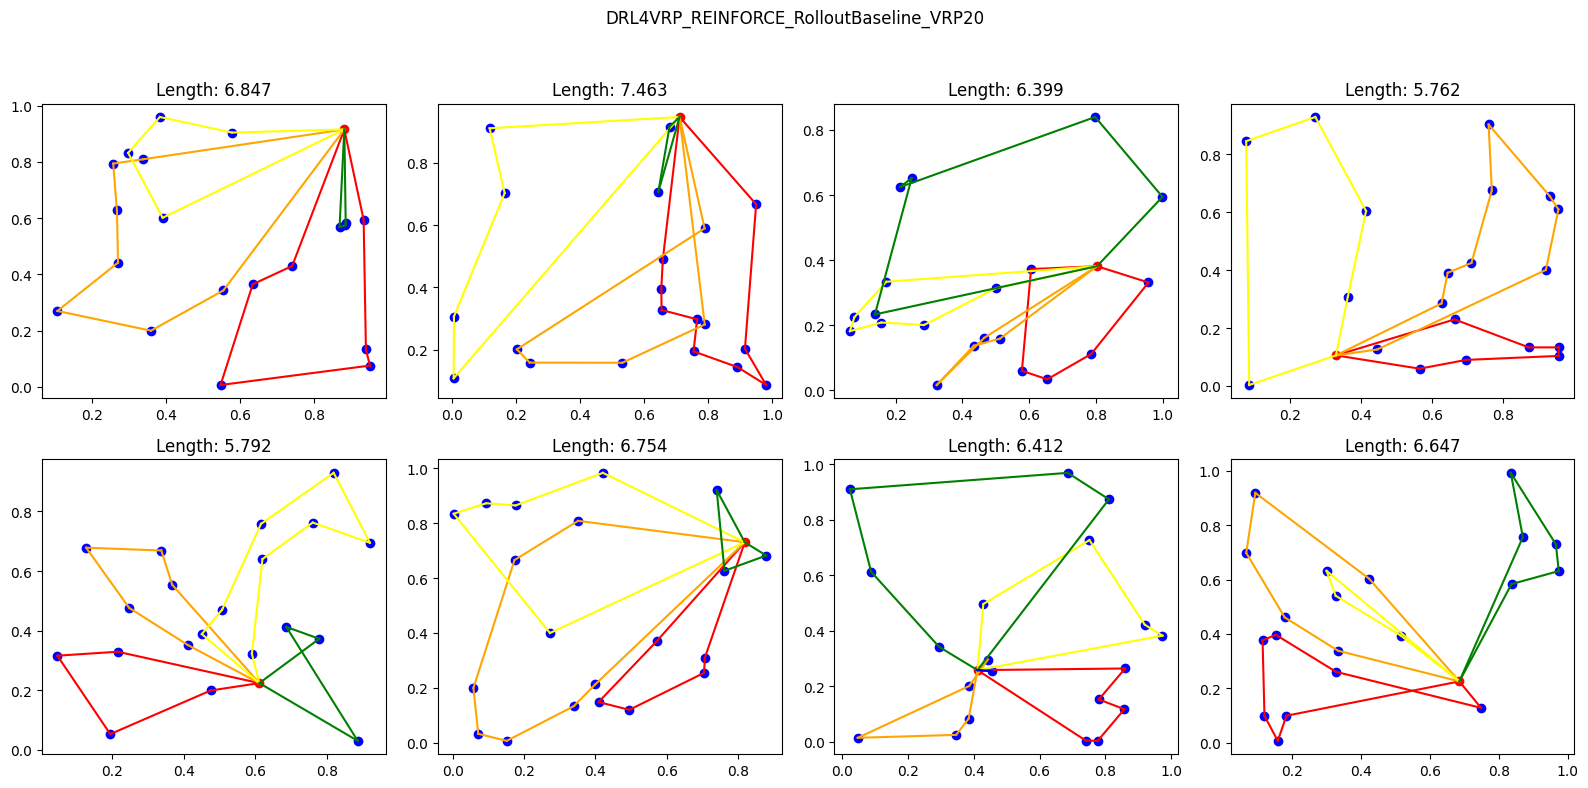

Test average reward: 6.4159
Test completed!


In [18]:
print('Test started...')
test2(args, test_dataset)
print('Test completed!')